In [ ]:
라이브러리 임포트

In [5]:
from time import time
import numpy as np
import matplotlib.pyplot as pylab

from dask import delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [4]:
유사-하르 특징 추출

(200, 25, 25)


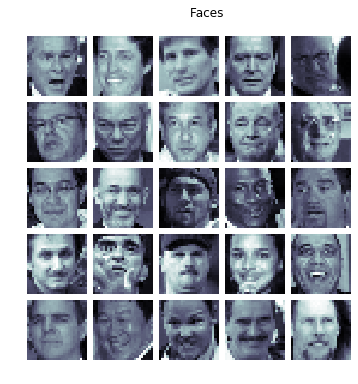

In [6]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """현재 영상을 위해 하르 특징 추출"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1], \
                             feature_type=feature_type, feature_coord=feature_coord)

images = lfw_subset()
print(images.shape) # (200, 25, 25)

fig = pylab.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=0.9, hspace=0.1, wspace=0.1)

for i in range(25):
    pylab.subplot(5,5,i+1)
    pylab.imshow(images[i], cmap='bone'), pylab.axis('off')
    pylab.suptitle('Faces')
pylab.show()

In [ ]:
부정 예(얼굴 아닌 영상)의 일부 영상 보기

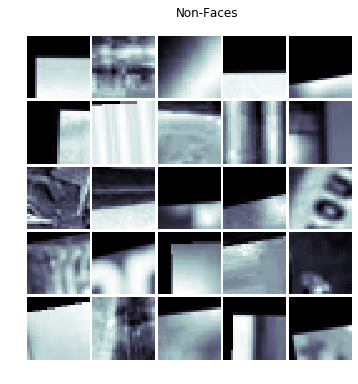

In [5]:
fig = pylab.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=0.9, hspace=0.05, wspace=0.05)

for i in range(25):    
    pylab.subplot(5,5,i+1)
    pylab.imshow(images[i+100], cmap='bone'), pylab.axis('off')
    
pylab.suptitle('Non-Faces')
pylab.show()

In [ ]:
랜덤 포레스트 앙상블 분류기로 얼굴 분류를 위해 중요한 유사-하르 특징 검색

C:\Users\bae22\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


19.149001598358154
(200, 101088) (150, 101088)
1.3220024108886719
1.0


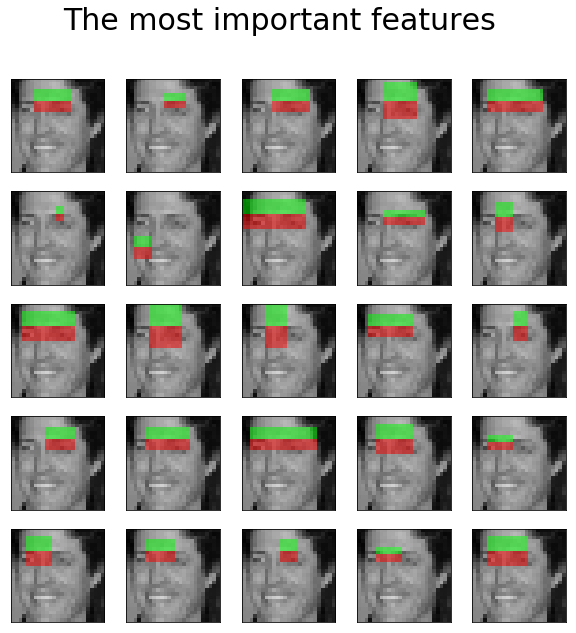

In [8]:
feature_types = ['type-2-x', 'type-2-y'] # 속도를 위해 첫 2개 특징 타입만 추출
# dask 모듈의 delayed() 함수를 사용하여 계산 그래프 작성
# 계산 단계를 위해 다중 CPU 사용 권장
X = delayed(extract_feature_image(img, feature_types) for img in images)

t_start = time()
X = np.array(X.compute(scheduler='processes'))
time_full_feature_comp = time() - t_start
y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,random_state=0, stratify=y)
print(time_full_feature_comp) # 104.87986302375793
print(X.shape, X_train.shape) # (200, 101088) (150, 101088)

from sklearn.metrics import roc_curve, auc, roc_auc_score # 모듈 임포트

# 가장 중요한 특징을 선택하기 위해 가능한 모든 특징 추출
_, h, w = images.shape
feature_coord, feature_type = haar_like_feature_coord(w, h, feature_types)
# 렌덤 포레스트 분류기 학습 및 성능 확인
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, \
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
print(time_full_train) # 1.6583366394042969
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(auc_full_features) # 1.0

# 중요한 순서대로 특징 정렬, 가장 중요한 6개 표시
idx_sorted = np.argsort(clf.feature_importances_)[::-1]
fig, axes = pylab.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    image = draw_haar_like_feature(images[1], 0, 0, w, h, \
                                   [feature_coord[idx_sorted[i]]])
    ax.imshow(image), ax.set_xticks([]), ax.set_yticks([])
    
fig.suptitle('The most important features', size=30)
pylab.show()

In [ ]:
HOG-SVM를 사용한 경계 박스 계산

357


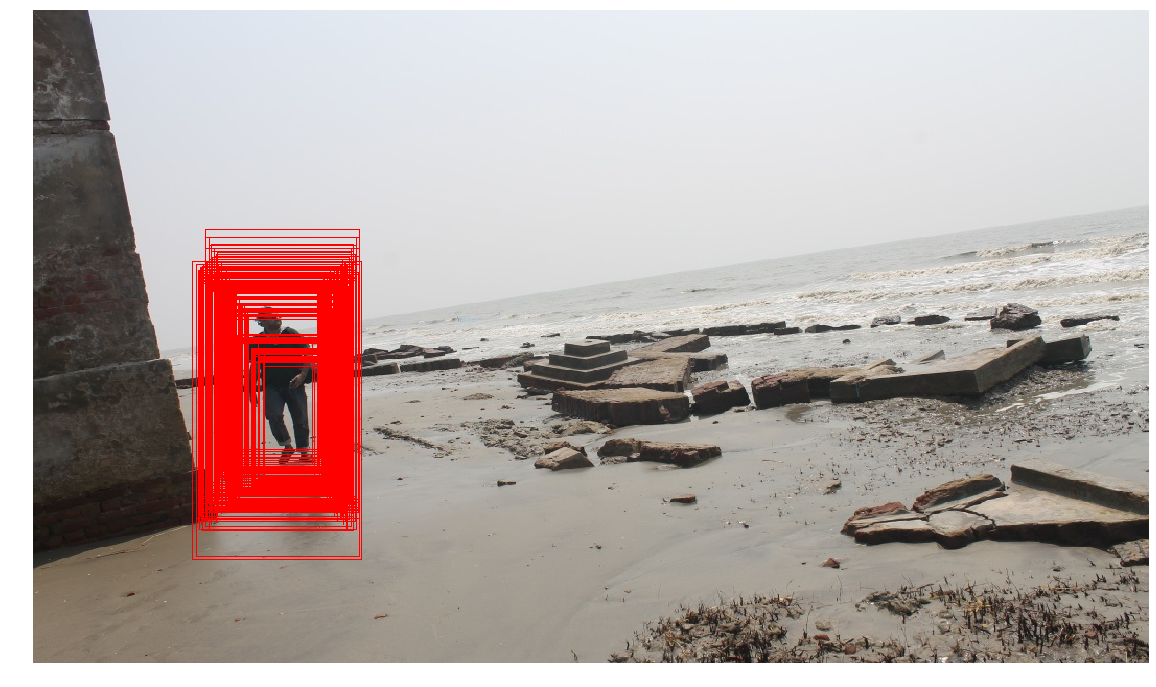

In [2]:
import cv2
import matplotlib.pylab as pylab
img = cv2.imread("../images/me16.jpg")

# 기본 사람(보행자) 검출기를 사용하여 HOG 서술자 생성
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
# 4화소 윈도우 보폭, 1.02의 확대, 그룹핑 없이 검출 실행(HOG가 확대
# 매개 변수에서 여러 위치에서 감지함을 보이기 위해)
(foundBoundingBoxes, weights) = \
      hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), \
                              scale=1.02, finalThreshold=0)
print(len(foundBoundingBoxes)) # 경계 박스 수 357개

# 원본 영상 복사하여 경계 박스 그림 – 원본 영상은 다시 사용 가능
imgWithRawBboxes = img.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
    cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh),\
                  (0, 0, 255), 1)
    
pylab.figure(figsize=(20, 12))
imgWithRawBboxes = cv2.cvtColor(imgWithRawBboxes, cv2.COLOR_BGR2RGB)
pylab.imshow(imgWithRawBboxes, aspect='auto'), pylab.axis('off')
pylab.show()

In [ ]:
비최대 억제

357 1


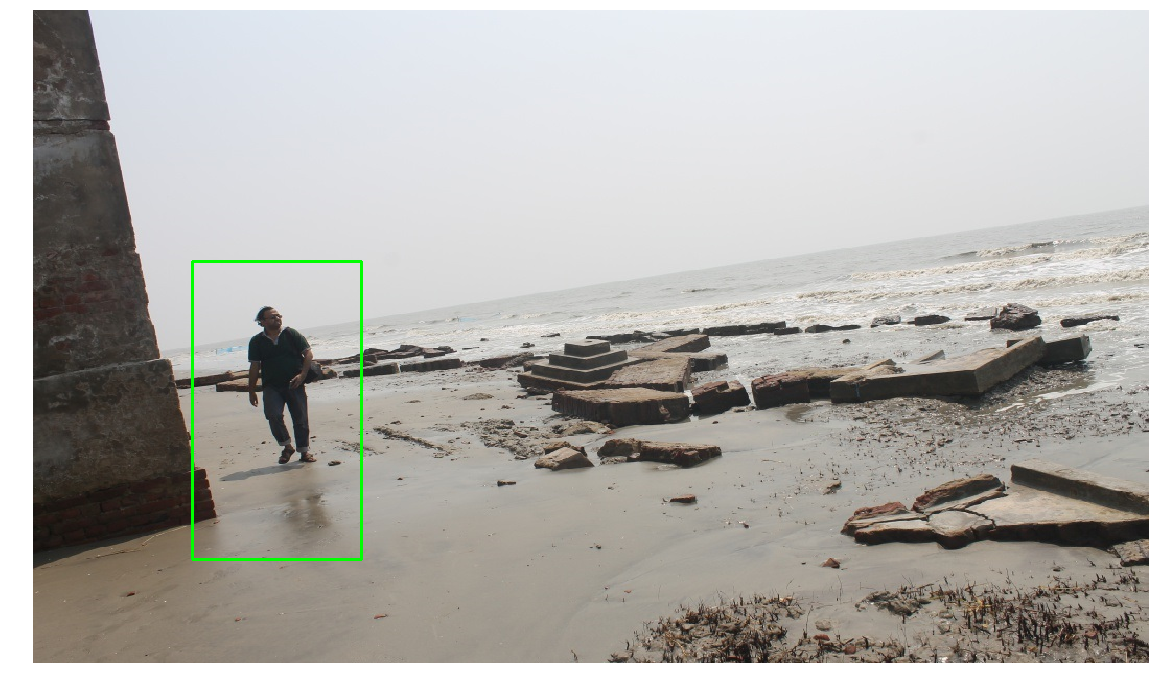

In [6]:
# 윈도우10에서 imutils 라이브러리는 아나콘다에 기본 포함이 아님
# pip install imutils을 통해서 라이브러리 설치 필요
from imutils.object_detection import non_max_suppression

# 경계 박스 형식 변환: (x,y, w,h) → (x1, y1, x2, y2)
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in foundBoundingBoxes])
# 오버레이 연산 65% 기준으로 비최대 억제 수행

nmsBoundingBoxes = non_max_suppression(rects, probs=None, 
                                       overlapThresh=0.65)
print(len(rects), len(nmsBoundingBoxes)) # 전체 박스 vs. 억제 박스 357: 1

# 영상에 최종 경계 박스 그리기
for (x1, y1, x2, y2) in nmsBoundingBoxes:
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
pylab.figure(figsize=(20, 12))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pylab.imshow(img, aspect='auto'), pylab.axis('off')
pylab.show()